# Transfer Learning - Xception Deep Learning Network improvement

Use of a pre-trained xception network, trained on imagenet data, to recognise over 120 dog breeds using the Stanford dogs dataset.

Author: Ben Fraser

---

In [1]:
import h5py
import keras
from keras import models, layers, optimizers
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import os
import pandas as pd
import pickle
import random

Using TensorFlow backend.


---

## 1. Import data and form directory structure suitable for a data generator

In [2]:
label_df = pd.read_csv('labels.csv')
labels = label_df.set_index('id')['breed']

In [3]:
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [5]:
labels.head()

id
000bec180eb18c7604dcecc8fe0dba07         boston_bull
001513dfcb2ffafc82cccf4d8bbaba97               dingo
001cdf01b096e06d78e9e5112d419397            pekinese
00214f311d5d2247d5dfe4fe24b2303d            bluetick
0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
Name: breed, dtype: object

In [6]:
y = pd.get_dummies(labels, sparse=True)
train_ids = y.index
test_ids = pd.read_csv('sample_submission.csv')['id']

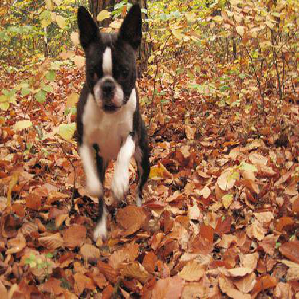

In [7]:
img_path = 'train/000bec180eb18c7604dcecc8fe0dba07.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img

### Folder subdirectory creation function for dog breed data

WARNING - only run the validation folder creation code snippet once, else we will end up loosing more and more training data.

In order to carry out data augmentation, we need to organise our data into directories so that there are subdirectories for each class we want to use in our model. This is so that the keras ImageDataGenerator class works effectively with its method flow_from_directory().

In [25]:
classes = label_df.breed.unique()

# create new training and validation subdirectories
os.mkdir('training')
os.mkdir('validation')

# create a sub-folder within each for each dog class
for dog_class in classes:
    os.mkdir('training/{}'.format(dog_class))
    os.mkdir('validation/{}'.format(dog_class))

In [26]:
# copy the relevant image data to each folder and subdirectory
m = labels.shape[0]

for i in range(m):
    dog_class = labels[i]
    img_name = labels.index[i] + '.jpg'
    original_path = 'train/' + img_name
    new_path = 'training/' + dog_class + '/' + img_name
    os.system('cp {0} {1}'.format(original_path, new_path))

print('Subdirectories created and images moved for training data.')

Subdirectories created and images moved for training data.


#### Validation data extraction from the training set

ONLY RUN ONCE - this will take a proportion of the training data from each class, as denoted by val_n:

In [27]:
# proportion of images to use for validation we'll use 20% (0.2)
val_n = 0.2

# for each of the dog class folders within the train directory, take a 
for dog_class in classes:
    train_images = os.listdir('training/{0}'.format(dog_class))
    val_image_no = int(round(len(train_images) * val_n))
    val_i = random.sample(train_images, val_image_no)
    for img in val_i:
        src_path = 'training/' + dog_class + '/' + img
        new_path = 'validation/' + dog_class + '/' + img
        os.rename(src_path, new_path)

print("Moved {} proportion of training images from each class into validation directory".format(val_n))

Moved 0.2 proportion of training images from each class into validation directory


---

## 2. Data Augmentation and Image pipelines

Use of Keras ImageDataGenerator to leverage our data and produce more images using the ones we already have.

We'll use an image size of 299 x 299, as per the original Xception network.

In [10]:
# dimensions of our images - set according to pretrained model (Xception), which is 299 by 299
img_width, img_height = 299, 299

# set destinations of train and validation directories
train_data_dir = 'dataset/training'
validation_data_dir = 'dataset/validation'
batch_size = 4

# augmentation on training image data
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# we dont want to augment test data - only rescale
test_datagen = ImageDataGenerator(rescale=1. / 255)

# generate batches of augmented data in the same directory as existing training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

# create pandas dataframes for our train data
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

Found 8185 images belonging to 120 classes.
Found 2037 images belonging to 120 classes.


---

## 3. Model formulation and training - Xception base with customised dense final-layers

In [8]:
Xception_base = xception.Xception(weights='imagenet', include_top=False)

In [11]:
# add a global spatial average pooling layer
x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
# create the full network so we can train on it
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

In [12]:
# compile our model with desired optimiser hyper-parameters
Xception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

#### Training of model: WARNING - only do this stage on personal computer if you have a Nvidia GPU

Normally, with a GPU enabled computer we would conduct this step, however in this case (with a MacBook Pro) it will take over 12 hours - skip this part and import our model trained from a cloud GPU instead.

In [ ]:
history = Xception_transfer.fit_generator(
    train_generator,
    epochs=50, shuffle = True, verbose = 1, validation_data = validation_generator)

#### Rather than train on laptop CPU - import model trained from cloud GPU

For this model I carried out the training in 10 parts, since the training can take a long time. Each of the ten iterations I carried out ranged from 10 - 20 iteration cycles at a time, where 10 iterations takes about 40 minutes on Google Collaboratory. 

With this in mind, the history consists of 10 dictionaries that need to be combined to form the full training history. We'll do this by importing the 10 history dictionaries and combining them into one Python dictionary.

We'll also import the latest iteration of the trained model, which is stored as a .h5 file.

In [13]:
Xception_transfer = models.load_model('trained_model/dog_breeds_xception_tl.h5')

OSError: Unable to open file (unable to open file: name = 'trained_model/dog_breeds_xception_tl.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [14]:
# get histories of trained (training was done in 10 stages)
with open('trained_model/trainHistoryDictDogBreedsXception_1.pickle', 'rb') as handle:
    history_1 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_2.pickle', 'rb') as handle:
    history_2 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_3.pickle', 'rb') as handle:
    history_3 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_4.pickle', 'rb') as handle:
    history_4 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_5.pickle', 'rb') as handle:
    history_5 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_6.pickle', 'rb') as handle:
    history_6 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_7.pickle', 'rb') as handle:
    history_7 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_8.pickle', 'rb') as handle:
    history_8 = pickle.load(handle)
    
with open('trained_model/trainHistoryDictDogBreedsXception_9.pickle', 'rb') as handle:
    history_9 = pickle.load(handle)

with open('trained_model/trainHistoryDictDogBreedsXception_10.pickle', 'rb') as handle:
    history_10 = pickle.load(handle)

In [15]:
# combine individual history dicts into one
history = dict()

history['acc'] = (history_1['acc'] + history_2['acc'] + history_3['acc'] + history_4['acc']
                  + history_5['acc'] + history_6['acc'] + history_7['acc'] 
                  + history_8['acc'] + history_9['acc'] + history_10['acc'])

history['val_acc'] = (history_1['val_acc'] + history_2['val_acc'] + history_3['val_acc'] + history_4['val_acc']
                  + history_5['val_acc'] + history_6['val_acc'] + history_7['val_acc'] 
                  + history_8['val_acc'] + history_9['val_acc'] + history_10['val_acc'])

history['loss'] = (history_1['loss'] + history_2['loss'] + history_3['loss'] + history_4['loss']
                  + history_5['loss'] + history_6['loss'] + history_7['loss'] 
                  + history_8['loss'] + history_9['loss'] + history_10['loss'])

history['val_loss'] = (history_1['val_loss'] + history_2['val_loss'] + history_3['val_loss'] + history_4['val_loss']
                  + history_5['val_loss'] + history_6['val_loss'] + history_7['val_loss'] 
                  + history_8['val_loss'] + history_9['val_loss'] + history_10['val_loss'])

This process could be done a lot more eloquently through a function, however it does the job crudely for now.

In [17]:
# save our one history file for future reference
with open('trained_model/trainHistoryDogBreedsXception.pickle', 'wb') as f:
    pickle.dump(history, f, protocol=2)

#### Visualise training history for our model

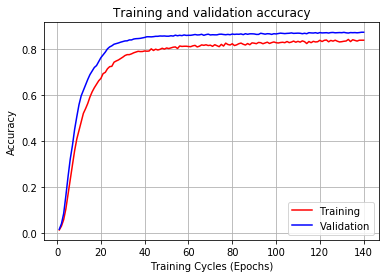

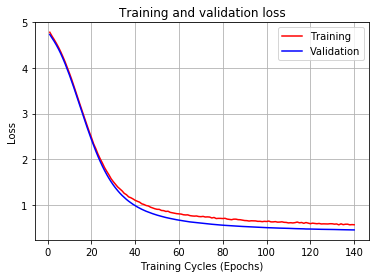


Final model:
train accuracy 0.8392 
val accuracy 0.8738 
train loss 0.5671 
val loss 0.4540


In [17]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training')
plt.plot(epochs, val_acc, 'blue', label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Training Cycles (Epochs)')
plt.grid()
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training')
plt.plot(epochs, val_loss, 'blue', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Training Cycles (Epochs)')
plt.grid()
plt.legend()

plt.show()

print('\nFinal model:\ntrain accuracy {0:.4f} \nval accuracy {1:.4f} \n'
      'train loss {2:.4f} \nval loss {3:.4f}'.format(history['acc'][-1],
                                                    history['val_acc'][-1],
                                                    history['loss'][-1],
                                                    history['val_loss'][-1]))

---
## 4. Making predictions using our trained model

Lets make a series of helper functions for making a prediction using the trained model:

In [4]:
def process_and_predict_img(image_path):
    """ Utility function for making predictions for an image. """
    img_path = image_path
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = test_datagen.standardize(x)
    predictions = Xception_transfer.predict(x)
    return img, predictions

In [5]:
# set location of our real-world image data
image_directory = 'dataset/training/'

# get class labels dict containing index of each class for decoding predictions
class_labels = train_generator.class_indices

In [21]:
# save the class_labels dict for use in other applications (e.g. Flask app) with our model
with open('dog_class_labels.pickle', 'wb') as file_pi:
        pickle.dump(class_labels, file_pi, protocol=2)

In [8]:
# import class labels for decoding predictions
with open('dog_class_labels.pickle', 'rb') as handle:
    class_labels = pickle.load(handle)

In [27]:
def dog_from_index(dog_index, dict_obj):
    """ Custom function to return dog name from argmax index. """
    dog_class = dict_obj.keys()[dict_obj.values().index(dog_index)]
    return dog_class

In [40]:
def top_n_predictions(predict_probs, top_n_labels=3):
    # obtain top n prediction indices for array of predictions
    top_indices = np.argpartition(predict_probs[0], -top_n_labels)[-top_n_labels:]
    
    # negate prediction array to sort in descending order
    sorted_top = top_indices[np.argsort(-predict_probs[0][top_indices])]
    
    # dict comp to create dict of labels and probs
    labels = {"label_" + str(i + 1) : (dog_from_index(index, class_labels).replace('_', ' '), predict_probs[0][index]) 
                     for i, index in enumerate(sorted_top)}
    return labels

###### Prediction on single image examples from the test set


Predicted dog: french_bulldog



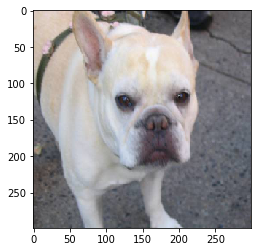

In [41]:
img, prediction = process_and_predict_img(image_directory + 'french_bulldog/2350636fa621328d21bd36798942b051.jpg')
print("\nPredicted dog: {}\n".format(dog_from_index(np.argmax(prediction, axis=-1)[0], class_labels)))
plt.imshow(img)
plt.show()

Lets adapt this further and include the top three predictions made by the model. This allows us to better understand the certainty (or uncertainty!) of our model when making its predictions.

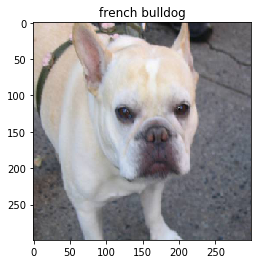

Top predictions:
- french bulldog: 91.18%
- boston bull: 2.58%
- boxer: 2.21%


In [59]:
img, prediction = process_and_predict_img(image_directory + 'french_bulldog/2350636fa621328d21bd36798942b051.jpg')
top_labels = top_n_predictions(prediction, top_n_labels=3)
plt.imshow(img)
plt.title(top_labels['label_1'][0])
plt.show()

print("Top predictions:")
for label in top_labels:
    print("- {0}: {1:.2f}%".format(top_labels[label][0], top_labels[label][1] * 100))

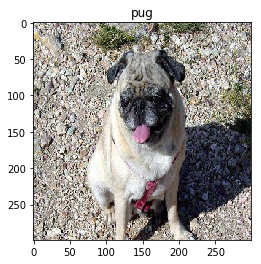

Top predictions:
- pug: 90.12%
- brabancon griffon: 2.06%
- bull mastiff: 1.60%


In [60]:
img, prediction = process_and_predict_img(image_directory + 'pug/0e403e86dc961d59fec94dfb62968a53.jpg')
top_labels = top_n_predictions(prediction, top_n_labels=3)
plt.imshow(img)
plt.title(top_labels['label_1'][0])
plt.show()

print("Top predictions:")
for label in top_labels:
    print("- {0}: {1:.2f}%".format(top_labels[label][0], top_labels[label][1] * 100))

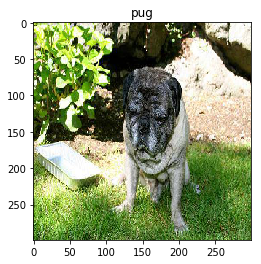

Top predictions:
- pug: 93.19%
- french bulldog: 2.15%
- bull mastiff: 1.23%


In [61]:
img, prediction = process_and_predict_img(image_directory + 'pug/4db214f01a18bc86674737115f96673e.jpg')
top_labels = top_n_predictions(prediction, top_n_labels=3)
plt.imshow(img)
plt.title(top_labels['label_1'][0])
plt.show()

print("Top predictions:")
for label in top_labels:
    print("- {0}: {1:.2f}%".format(top_labels[label][0], top_labels[label][1] * 100))

The performance is brilliant - we'll now try this on a much greater range of test images in the next section.

#### Predictions on various dog images from the test directory:

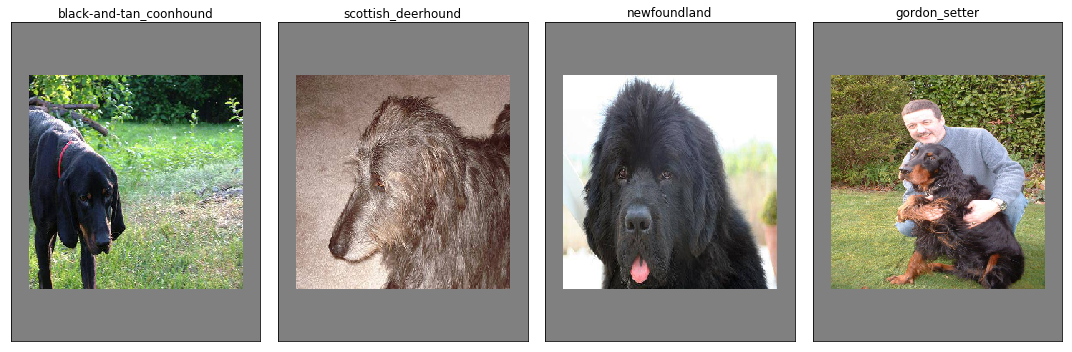

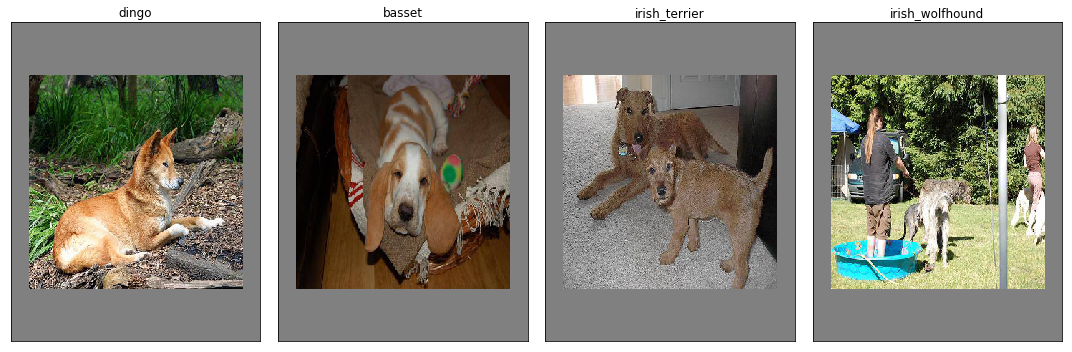

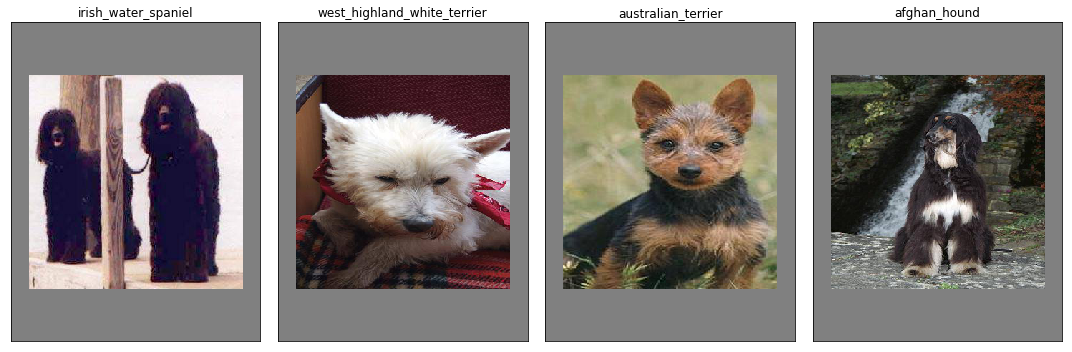

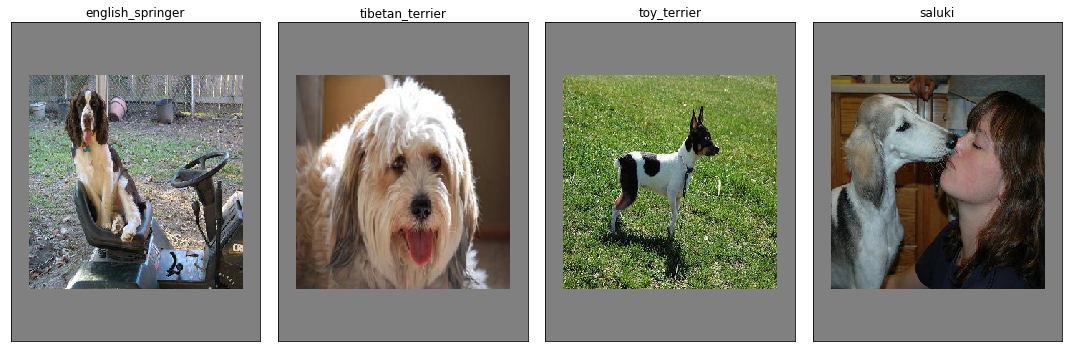

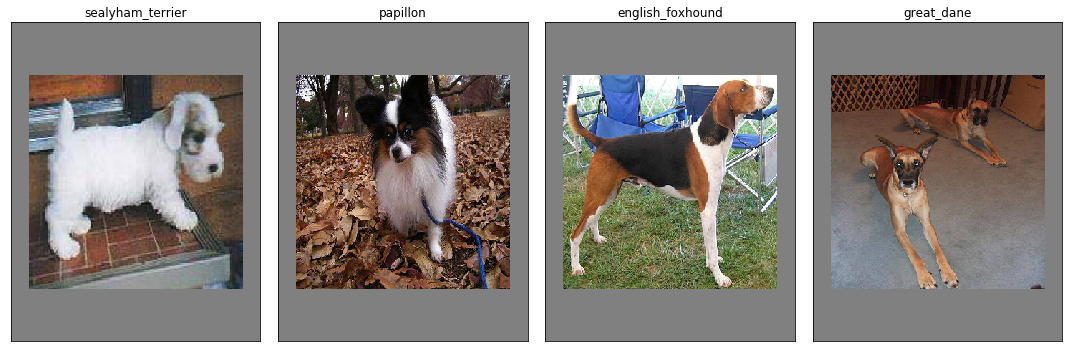

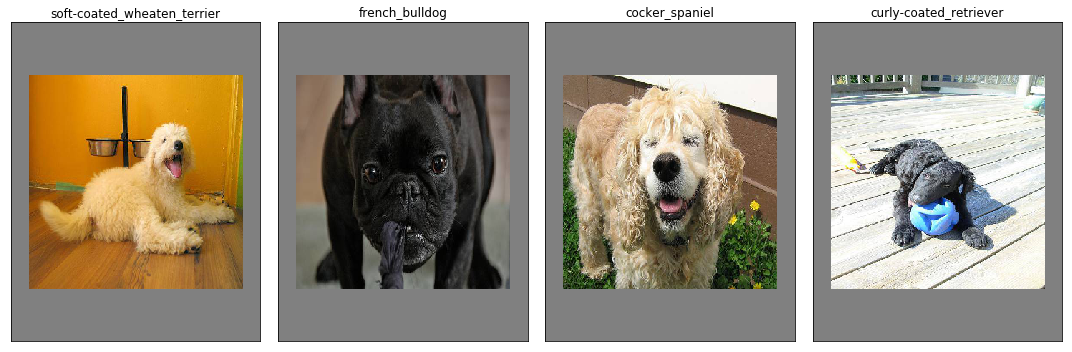

In [25]:
test_dir = 'test/'
test_images = os.listdir('test')[:24]
img_num = 0

for i in range(6):
    fig, ax = plt.subplots(nrows = 1, ncols = 4, sharex = True, sharey = True, figsize=(15,5))
    ax = ax.flatten()
    ax_no = 0
    for j in range(4):
        img_path = test_dir + test_images[img_num]
        img, predictions = process_and_predict_img(img_path)
        ax[ax_no].imshow(img)
        ax[ax_no].set_title(dog_from_index(np.argmax(predictions, axis=-1)[0], class_labels))
        ax[ax_no].patch.set_facecolor('grey')
        ax_no += 1 
        img_num += 1
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

Not bad! Considering the sheer number of different dog types used (120), our model is impressively accurate at predicting dogs in images it has not been exposed to before!

To finish, we'll make a few predictions on some of my own dogs...


Predicted dog: cocker_spaniel



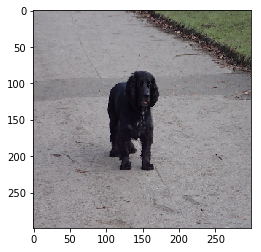

In [27]:
img, prediction = process_and_predict_img('lemmy.jpg')
print("\nPredicted dog: {}\n".format(dog_from_index(np.argmax(prediction, axis=-1)[0], class_labels)))
plt.imshow(img)
plt.show()


Predicted dog: bull_mastiff



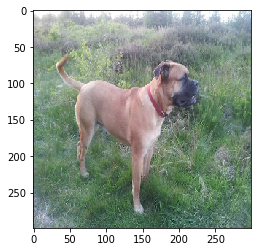

In [28]:
img, prediction = process_and_predict_img('cassie.jpg')
print("\nPredicted dog: {}\n".format(dog_from_index(np.argmax(prediction, axis=-1)[0], class_labels)))
plt.imshow(img)
plt.show()

Both my dogs were very well classified - Cassie is indeed a Bull Mastiff, and Lemmy is actually a sprocker spaniel, but cocker spaniel really is the closest you can expect to a sprocker in this case.

---

## 5. Adapting this model further - Web Application

After training this model, a sample web application was produced using Flask. This allows any custom image of a dog to be uploaded to the application, which will then predict the breed of dog, including its top three predictions for the given image. The source code for this application is available at: https://github.com/BenjaminFraser/Dog-Breed-Classifier-App.

Please take a look and star if you like!